# **Chap 6：计算机视觉**

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
from source.code import ch6
from source.code import utils

2023-05-14 17:50:45.527187: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-14 17:50:45.664240: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-14 17:50:45.706008: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-14 17:50:46.465694: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
# 如果你要在服务器上和别人共用GPU，可以设置你需要的显存资源
utils.gpu_limitation_config(memory=30,device=2)

## **6.2 边界框预测和多尺度检测**

### **6.2.1 使用非极大值抑制预测边界框**

模型预测时，会根据采样得到的锚框，预测**锚框的类别，以及其到真实边界框的偏移**，因此，我们需要将锚框结合偏移**逆变换得到预测的真实边界框**，函数 `offset_inverse` 实现了这个功能，它可以看作 `offset_boxes` 的”**反函数**“

`offset_boxes` 实现的变换：
$$ (O_x,O_y,O_w,O_h) = 
\left( \frac{ \frac{x_B - x_A}{w_A} - \mu_x }{\sigma_x},
\frac{ \frac{y_B - y_A}{h_A} - \mu_y }{\sigma_y},
\frac{ \log \frac{w_B}{w_A} - \mu_w }{\sigma_w},
\frac{ \log \frac{h_B}{h_A} - \mu_h }{\sigma_h}\right),
$$

需要进行的逆变换实现的变换：
$$
\left( 
(O_x\sigma_x + \mu_x)w_A + x_A,
(O_y\sigma_y + \mu_y)h_A + y_A,
\exp{(O_w\sigma_w + \mu_w)}w_A,
\exp{(O_h\sigma_h + \mu_h)}h_A\right),
$$

In [9]:
def offset_inverse(anchors, offset_preds):
    # 将锚框转换为中心表示
    anchors = ch6.box_corner_to_center(anchors) # (A_X, A_Y, A_W, A_H)
    # 根据偏移量计算预测边界框的中心和宽高
    pred_bbox_xy = (offset_preds[:, :2] * anchors[:, 2:] / 10) + anchors[:, :2]
    pred_bbox_wh = tf.math.exp(offset_preds[:, 2:] / 5) * anchors[:, 2:]
    pred_bbox = tf.concat([pred_bbox_xy, pred_bbox_wh], axis=1)
    # 将预测边界框转换为对角表示
    pred_bbox = ch6.box_center_to_corner(pred_bbox)
    return pred_bbox

在采样许多锚框进行预测时，可能会**输出很多相似的，大部分区域重叠的预测边界框**，它们围绕这同一个目标，为了简化输出，我们可以使用**非极大值抑制**（**non-maximum suppression**，简称**NMS**）**合并属于同一目标的类似的预测边界框**

对于一个预测边界框 $B$，模型会计算 $B$ 属于每个类别的概率，假设最大的预测概率为 $p$，则该概率所对应的类别 $C$ 就作为边界框 $B$ 的类别，而概率 $p$ 称为**预测边界框的置信度**，在同一张图像中，**所有预测的非背景边界框按照置信度降序排列**，生成列表 $L$，然后按下面步骤排序列表 $L$：
1. 从 $L$ 中选取置信度最高的边界框 $B_1$ 作为基准，**将所有与** $B_1$ **的 IoU 超过阈值** $c$ **的非基准预测边界框从** $L$ **中移除**，则 $L$ **保留了置信度最高的预测边界框**，去除了与其太相似的其他预测边界框，即**那些具有非极大值置信度的边界框被抑制了**
2. 从 $L$ 中选取置信度第二高的边界框 $B_2$ 作为新的基准，执行刚才相同的操作
3. 重复上述过程，直到 $L$ 中的**所有边界框都曾用作基准**，并且它们**任意二者的 IoU 都小于阈值** $c$
4. 输出列表 $L$ 中的所有预测边界框，此时**没有一对过于相似的边界框**

函数 `non_maximum_suppression` **按降序对置信度进行排序并返回索引**，函数已经写入 `./source/code/ch6.py`
* 为了**使算法高效执行**，我们使用了掩码 `valid_mask` 的技巧，通过更新 `valid_mask` 将所有操作变为向量化运算
* 参数 `max_num_bbox` 可以**控制 NMS 搜索得到的最大真实边界框数量**，这一参数可以很好的减少搜索次数，提高算法效率

In [3]:
def non_maximum_suppression(boxes, probs, iou_threshold, max_num_bbox : int=None):
    """
    ### 非极大值抑制

    Parameters
    ----------
    boxes : tf.Tensor
        预测边界框，形状：(num_pred, 4)
    probs : tf.Tensor
        预测边界框的置信度，形状：(num_pred, )
    iou_threshold : float
        IoU 阈值
    max_num_bbox : int, default = `None`
        最大保留的预测边界框数量，如果为 `None`，则最多保留 `probs` 中的所有元素

    Returns
    -------
    keep : tf.Tensor
        保留的预测边界框索引
    """
    if max_num_bbox is None:
        max_num_bbox =  tf.shape(probs)[0]

    # 根据预测边界框的置信度排序
    order = tf.argsort(probs, direction='DESCENDING') # 降序排列
    # 初始化保留预测边界框的索引
    keep = []

    # 计算 boxes 两两之间的 IoU
    pairwise_IoU = ch6.box_IoU(boxes, boxes) # 形状：(num_pred, num_pred)
    pairwise_mask = pairwise_IoU <= iou_threshold
    valid_mask = tf.ones_like(probs, dtype=tf.bool) # 形状：(num_pred, )
    valid_count = tf.shape(probs)[0]

    while valid_count > 0 and len(keep) < max_num_bbox:
        # 获取第一个有效的索引
        i = order[tf.argmax(valid_mask)]
        keep.append(i)

        # 更新 valid_mask
        valid_mask = tf.logical_and(valid_mask, tf.gather(pairwise_mask[i],order))
        # 更新 valid_count
        valid_count = tf.reduce_sum(tf.cast(valid_mask, tf.int32))

    return tf.stack(keep)

Tensorflow 也提供了 NMS 的 API，你可以使用 `tf.image.non_max_suppression()`，这是一种更高效的实现方式

函数 `multibox_detection` 实现非极大值抑制预测边界框，函数已经写入 `./source/code/ch6.py`

In [9]:
def multibox_detection(cls_probs, offset_preds, anchors, 
                       nms_threshold : float=0.5, pos_threshold : float=0.001):
    """
    ### 多尺度目标检测

    Parameters
    ----------
    cls_probs : tf.Tensor
        预测类别概率分布，形状：(batch_size, num_anchor, num_class + 1)
    offset_preds : tf.Tensor
        预测边界框偏移量，形状：(batch_size, 4*num_anchor)
    anchors : tf.Tensor
        锚框，形状：(num_anchor, 4)
    nms_threshold : float, default = 0.5
        非极大值抑制阈值
    pos_threshold : float, default = 0.001
        正类阈值
    
    Returns
    -------
    output : tf.Tensor
        检测结果，形状：(batch_size, num_detection, 6)
    """
    batch_size, num_anchor = cls_probs.shape[0], anchors.shape[0]
    # 初始化输出
    output = []
    for i in range(batch_size):
        # 取出第 i 个样本的预测类别概率和边界框偏移量
        cls_prob  = cls_probs[i] # 形状：(num_class + 1, num_anchor)
        offset_pred = tf.reshape(offset_preds[i], (-1, 4)) # 形状：(num_anchor, 4)
        # 计算非背景类别的置信度 conf，取出对应的类别编号 class_id
        conf = tf.reduce_max(cls_prob[:,1:], axis=1) # 形状：(num_anchor, )
        # 这里将结果转化为 numpy 数组，因为后续要通过索引修改数组元素
        class_id = tf.cast(tf.argmax(cls_prob[:,1:], axis=1), dtype=tf.float32) # 形状：(num_anchor, )

        # 利用偏移量 offset 预测边界框
        pred_bbox = ch6.offset_inverse(anchors, offset_pred) # 形状：(num_anchor, 4)
        # NMS 计算保留的预测边界框索引
        keep = ch6.non_maximum_suppression(pred_bbox, conf, nms_threshold) # 形状：(num_detection, )

        # 找到所有的 non_keep 索引，并将类设置为背景 
        all_idx = tf.range(num_anchor, dtype=tf.int32) # 形状：(num_anchor, )
        combined = tf.concat([keep, all_idx], axis=0) # 形状：(num_detection + num_anchor, )

        # 找到 combined 中的非重复元素，即为 non_keep 索引
        unique, _, counts = tf.unique_with_counts(combined)
        non_keep = unique[counts == 1] # counts == 1 表示非重复元素
        all_idx_sorted = tf.concat([keep, non_keep], axis=0) # 形状：(num_anchor, )

        # 设置背景类别标签，-1 表示背景类别
        class_id = tf.tensor_scatter_nd_update(
            class_id, non_keep[:,None], tf.fill(non_keep.shape[0], -1.0))
        # 对预测结果进行排序，高置信度的类别排在前面，后面是背景类别
        class_id = tf.gather(class_id, all_idx_sorted)
        conf = tf.gather(conf, all_idx_sorted)
        pred_bbox = tf.gather(pred_bbox, all_idx_sorted)

        # pos_threshold 为正类阈值，如果置信度小于阈值，同样设置为背景
        below_pos_idx = (conf < pos_threshold)
        num_below_pos = tf.reduce_sum(tf.cast(below_pos_idx, tf.int32))
        class_id = tf.tensor_scatter_nd_update(
            class_id, tf.where(below_pos_idx), tf.fill(num_below_pos, -1.0))

        # 修改置信度 conf 中背景部分的概率为 1 - conf，用 tf.where 实现
        conf = tf.where(below_pos_idx, 1 - conf, conf) # 形状：(num_anchor, )

        # 拼接预测信息，形状：(num_anchor, 2 + 4 = 6)
        # 6个元素分别为：类别编号、置信度、边界框坐标
        pred_info = tf.concat([tf.expand_dims(class_id, axis=-1),
                               tf.expand_dims(conf, axis=-1),
                               pred_bbox], axis=-1)
        # 添加到输出
        output.append(pred_info)
    
    return tf.stack(output)

最后，我们来测试上面实现的边界框预测算法
* 我们生成四个锚框，处于**简单起见，假设基于它们预测的偏移量** `offset` **均为零**，这意味着**预测的边界框就是锚框**
* 我们再假设了锚框分别属于背景、狼和羊的概率分布

In [6]:
# 生成锚框
anchors = tf.constant([[0.45, 0.45, 0.95, 0.90], 
                       [0.35, 0.40, 0.90, 0.85],
                       [0.50, 0.55, 0.85, 0.95], 
                       [0.08, 0.10, 0.55, 0.70]], dtype=tf.float32)
# 假设对应的偏移量全为 0
offset_preds = tf.constant([0.0] * tf.size(anchors).numpy())
# 假设锚框预测的类别概率分布，背景类别概率全为 0
# 注意形状为 (num_class + 1, num_anchor)，所以列和为 1
cls_probs = tf.constant([[0.0, 0.9, 0.1],
                         [0.0, 0.8, 0.2],
                         [0.0, 0.7, 0.3],
                         [0.0, 0.1, 0.9]])

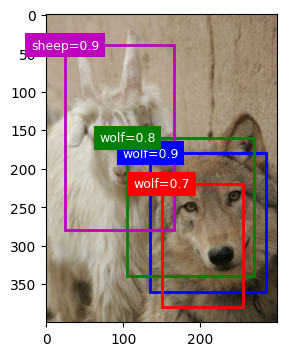

In [7]:
img = plt.imread("./source/Chap6/wolf_sheep.png")
# 获取高度和宽度
h, w = img.shape[0], img.shape[1]
bbox_scale = tf.constant([w, h, w, h], dtype=tf.float32)
fig = plt.figure(figsize=(3, 4))
plt.imshow(img)
ch6.show_bboxes(fig.axes[0], anchors * bbox_scale,
                labels=['wolf=0.9', 'wolf=0.8', 'wolf=0.7', 'sheep=0.9'])

调用 `multibox_detection` 执行非极大值抑制预测，NMS 阈值设置为 `nms_threshold = 0.5`
* 我们需要给 `offset_preds`，`cls_probs` **添加批量维度**

In [10]:
output = multibox_detection(tf.expand_dims(cls_probs, axis=0),
                            tf.expand_dims(offset_preds,axis=0),
                            anchors, nms_threshold=0.5)
np.set_printoptions(precision=2) # 设置显示的小数点精度
# 第一列是类别，-1 表示背景类别
# 第二列是置信度，后面四列是预测边界框坐标
output.numpy()

array([[[ 0.  ,  0.9 ,  0.45,  0.45,  0.95,  0.9 ],
        [ 1.  ,  0.9 ,  0.08,  0.1 ,  0.55,  0.7 ],
        [-1.  ,  0.8 ,  0.35,  0.4 ,  0.9 ,  0.85],
        [-1.  ,  0.7 ,  0.5 ,  0.55,  0.85,  0.95]]], dtype=float32)

接下来，我们**绘制非极大值抑制预测边界框的结果**，删除背景类别 `class = -1`

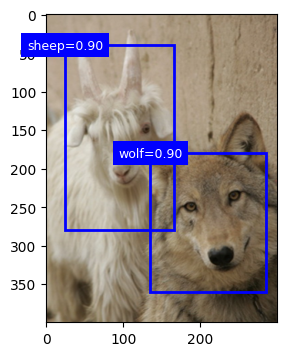

In [11]:
fig = plt.figure(figsize=(3, 4))
plt.imshow(img)
for bbox in output[0]:
    if bbox[0] == -1: # 跳过背景类别
        continue
    label = ('wolf=%.2f' if bbox[0] == 0 else 'sheep=%.2f') % bbox[1]
    ch6.show_bboxes(fig.axes[0], tf.reshape(bbox[2:], (-1, 4)) * bbox_scale, label)

实践中，上面的边界框预测算法还能进一步优化，例如：
* 在**执行非极大值抑制前**，我们可以**将置信度较低的预测边界框移除**，从而**减少此算法中的计算量**
* 我们也可以对非极大值抑制的**输出结果进行后处理**，例如，**只保留置信度更高的结果**作为最终输出

### **6.3.2 多尺度目标检测**

在锚框生成的过程中，我们**以输入图像的每个像素为中心，生成了多个锚框**，基本上，这些锚框代表了**图像不同区域的样本**
* 但如果为每个像素都生成的锚框，我们最终可能**会得到太多样本**，假设图像高宽为 $500\times 500$，每个像素为中心生成五个形状不同的锚框，那么一张图像就需要标记和预测约 $500\times 500\times 5 = 1250000$ 个锚框

事实上，我们可以减少锚框的数量，例如：
* 可以**在输入图像中均匀采样一小部分像素**，并以它们为中心生成锚框
* 可以**在不同尺度下，生成不同数量和不同大小的锚框**，具体来说：
    * 比起较大的目标，**较小的目标在图像上出现的可能性更多样**
    * 考虑 $5\times 5$ 和 $90\times 90$ 的两个锚框出现在 $100\times 100$ 的图像中，**前者可以非常灵活地出现在图像中的任意位置，而后者可以移动的范围就小很多**
    * 因此，使用**较小的锚框检测小物体时，可以采样更多区域**，而对于较大的锚框，就采样较少的区域

函数 `ch6.generate_multi_bbox()` 在宽高为 $h\times w$ 图像的每个像素处生成锚框，借助此，我们可以实现**多尺度锚框的均匀生成**
* 假设我们想要在图像中均匀生成 `fmap_h` 行，`fmap_w` 列个锚框，我们就提供给函数 `generate_multi_bbox()` 一个 `fmap_h * fmap_w` 为高宽的图像作为输入，它充当**特征图**
* `generate_multi_bbox()` 生成的锚框坐标是**相对位置坐标**，这些值介于 $[0,1]$ 之间，因此最后**乘以原始图像的高宽就可以得到所需的锚框坐标**
* 假设缩放比和宽高比满足 `m = len(sizes), n = len(ratios)`，则最终**生成的锚框数量为** `fmap_h * fmap_w * (m+n-1)`

In [13]:
def generate_multi_scale_bbox(fmap_h : int, fmap_w : int, size : float, 
                              width : int, height : int, ratios : list = [1, 2, 0.5]):
    # 生成多尺度锚框
    # 构建特征图 fmap
    fmap = tf.zeros((1, fmap_h, fmap_w, 3)) # 形状：(batch_size, height, width, channels)
    # 生成锚框的相对坐标
    anchors = ch6.generate_multi_bbox(fmap, sizes=[size], ratios=ratios)
    bbox_scale = tf.constant([width, height, width, height], dtype=tf.float32)
    return anchors * bbox_scale

首先，让我们考虑**探测小目标**，将锚框尺寸设置为 `size = 0.15`
* 特征图 `fmap` 的高度宽度设置为 `fmap_h = 4`，`f_map_w = 3`

In [14]:
img = plt.imread("./source/Chap6/wolf_sheep.png")
h, w = img.shape[0:2]
anchors = generate_multi_scale_bbox(fmap_h=4, fmap_w=3, size=0.15, width=w, height=h)

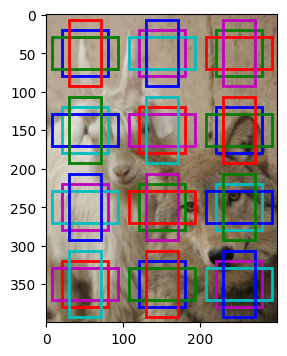

In [15]:
fig = plt.figure(figsize=(3, 4))
plt.imshow(img)
ch6.show_bboxes(fig.axes[0], anchors)

然后，我们考虑**检测中等大小的目标**，将特征图适当缩小，并方法尺度参数 `size = 0.25`

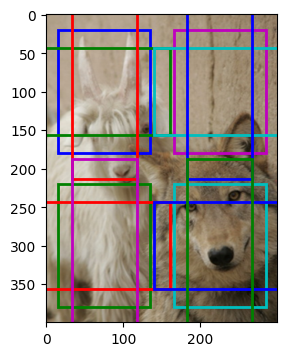

In [16]:
anchors = generate_multi_scale_bbox(fmap_h=2, fmap_w=2, size=0.40, width=w, height=h)
fig = plt.figure(figsize=(3, 4))
plt.imshow(img)
ch6.show_bboxes(fig.axes[0], anchors)

如果要检测较大的目标，可以继续缩小特征图，然后放大尺度参数 `size = 0.7`

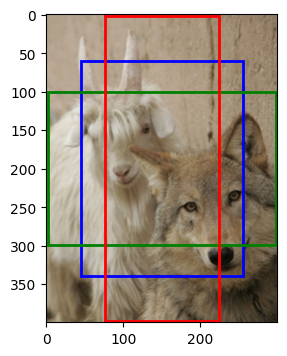

In [17]:
anchors = generate_multi_scale_bbox(fmap_h=1, fmap_w=1, size=0.70, width=w, height=h)
fig = plt.figure(figsize=(3, 4))
plt.imshow(img)
ch6.show_bboxes(fig.axes[0], anchors)

**结合 CNN，基于生成得多尺度锚框**，我们可以设计一种**多尺度目标检测模型**
* 假设在卷积神经网络得中间输出上，我们有**通道数为** $c$，高宽为 $h\times w$ 得**特征图**，使用前面的方法，我们可以**生成** $hw$ **组锚框**，其中**每组都有** $a$ **个中心相同的锚框**（这里 $a = n + n -1$，与尺度 `sizes` 和宽高比 `ratios` 数量有关），例如上面的演示中，$a = 3$，每组包含 3 个中心相同的锚框
* 每个锚框都根据真实边界框标记了类别 `class` 和偏移量 `offset`，**在当前尺度下，目标检测模型需要预测输入图像上** $hw$ **组锚框的类别和偏移量**，**不同组的锚框有不同的像素中心**
* $c$ 个通道的特征图是 CNN 的中间层输出，每张特征图上都有 $hw$ 个不同的空间位置，那么**相同的空间位置上，可以看作包含** $c$ **个单元**，根据 **CNN 感受野**的定义，特征图**在相同空间位置**的 $c$ 个单元**在原始输入上的感受野完全相同**，它们共同表征了同一感受野内的输入图像的信息
* 因此，我们可以**将特征图在同一空间位置的** $c$ **个通道单元**变换为**使用该空间位置生成的** $a$ **个锚框类别和偏移量**，其本质上是**使用该空间区域对应的感受野范围内的输入图像信息**，然后预测图像上与该区域位置相近的锚框类别和偏移量
* **CNN 不同的层感受野大小不同**，越靠近深层的部分，感受野越大，因此**不同卷积层的特征图可以用于检测不同大小的目标**
    * 例如，靠近输出的特征图单元具有更大的感受野，它们可以用来从输入中检测较大的目标
* 利用**深层 CNN 在多个层次上对图像进行分层表示**，按照上述的流程，就实现了多尺度目标检测

我们将在 **6.3 节**中具体实现该模型

### **6.2.3 目标检测数据集**

目标检测数据集的规模一般都很大，例如 **COCO**数据集，为了简化任务，我们从 Kaggle 上下载了数据集大小较小的**水果目标检测**数据，以展示目标检测模型的工作，`fruit_mini` 数据中包含了**苹果、香蕉和橙子**三种水果的独立图像，或者多种水果的混合图像，并且**标注了目标类别和真是边界框信息**

我们演示的数据集文件保存在 `./source/data/cv/fruit_mini` 文件夹中，它的文件目录结构如下：
* `fruit_mini`
    * `train`
        * `images`
        * `labels`
    * `valid`
        * `images`
        * `labels`

**训练集和验证集分别存储**在 `train` 和 `valid` 文件夹，**图像和对应的标签信息又分别存储**在 `iamges` 和 `labels` 文件夹中

函数 `load_detection_data()` 帮助我们读取水果目标检测数据集，其中 `dataset` **参数控制读取训练集还是验证集**
* `images` 和 `labels` 的文件名应该一一对应，一张图片对应一个标签文件
* 标签 `labels` 保存 `.txt` 文件，其中每行表示图像中的一个**真实边界框的类别的对角坐标**，即 `[class_id x0 y0 x1 y1]`
    * 因为每张图像的像素大小不同，通常我们会采用**相对位置**来标记边界框
    * 如果数据集提供的边界框坐标是绝对坐标，可以**预处理时除以高宽转换为相对坐标**
* **目标检测任务的图像大小一般都不相同**，在预处理阶段，为了便于卷积神经网络处理，我们可以**将它们的高宽统一到相同尺寸**，同时将像素除以 255 完成**像素归一化**

In [18]:
def load_detection_data(path : str, dataset : str="train", resize : list=[256, 256]):
    import os
    path_dir = os.path.join(path, dataset) + "/"
    # 初始化图像和标签列表
    images, labels = [], []

    # 获取文件夹下的所有文件名
    filenames = os.listdir(path_dir + "images")
    for file in filenames:
        # 图像路径 和 标签路径
        image_path = path_dir + "images/" + file
        label_path = path_dir + "labels/" + file[:-4] + ".txt"
        
        # 读取图像
        img = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3)
        img = tf.cast(img, dtype=tf.float32) / 255.0 # 转换为浮点数
        # 转换为相同尺寸
        img = tf.image.resize(img, resize)
        
        # 读取标签
        label = []
        with open(label_path, "r") as f:
            # 读取每一行
            for line in f.readlines():
                # 获取类别和边界框
                label.append([float(x) for x in line.split()])
        # 转换为张量
        label = tf.constant(label, dtype=tf.float32)

        # 添加到列表
        images.append(img)
        labels.append(label)
    print("read %s dataset with %d images"%(dataset, len(images)))
          
    return images, labels

In [19]:
train_images, train_labels = ch6.load_detection_data(
    path="./source/data/cv/fruit_mini",dataset="train")

2023-05-08 11:04:06.796984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-08 11:04:07.162183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-08 11:04:07.410998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


read train dataset with 240 images


2023-05-08 11:04:08.535311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


我们来可视化几个图像和真实边界框的样例

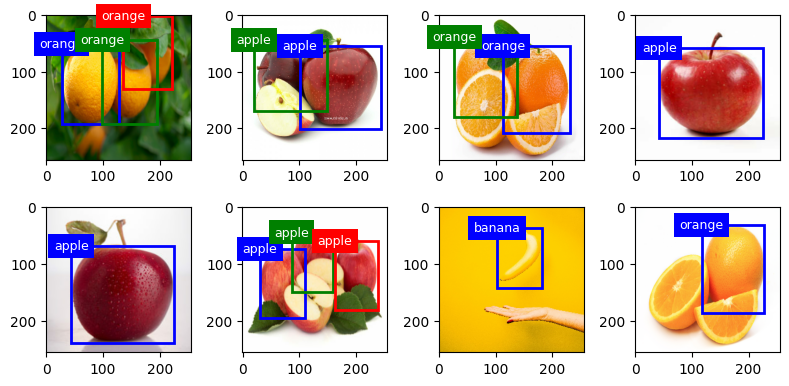

In [20]:
bbox_scale = tf.constant([256, 256, 256, 256], dtype=tf.float32)
fig,ax = plt.subplots(2, 4, figsize=(8, 4))
ax = ax.flatten()
for i in range(8):
    ax[i].imshow(train_images[i].numpy())
    ch6.show_bboxes(ax[i], bboxes=train_labels[i][:,1:] * bbox_scale,
                    labels=[ch6.FRUIT_MINI_CLASSES[train_labels[i][j,0].numpy().astype('int')] 
                            for j in range(len(train_labels[i]))])
plt.tight_layout()

接下来，我们创建**目标检测数据集的批量数据迭代器**，它将每个批量的输入图像 `X` 和标签信息 `Y` 返回
* 输入图像 `X` 的形状应该为 `(batch_size, height, width, 3)`，这与我们在 **CNN 时候见到的输入图像数据是相同的**
* 标签信息 `Y` 的形状应该为 `(batch_size, m, 5)`，其中，`m` **表示数据集中任何图像边界框可能出现的最大数量**
    * 可以观察到，**不同图像的真实边界框数量是不相同**
    * 为了将数据按照小批量拼接在一起，我们需要**通过填充将边界框数量填充至** `m` 个
    * 边界框少于 `m` 的图像将被**非法边界框填充**，将其**类别** `class_id` **设置为 -1 进行标识**，在模型计算时就可以进行过滤

In [21]:
class DetectionDataLoader:
    def __init__(self, path : str, dataset : str, resize : list=[256,256], batch_size : int=32):
        # 读取数据集
        self.X, self.Y = ch6.load_detection_data(path, dataset, resize)
        # 找到每个图像中的最大边界框数
        self.m = max([len(y) for y in self.Y])

        # 将边界框填充为 m 个
        for i,y in enumerate(self.Y):
            # y : tf.Tensor，形状为 (n, 5)，n 是边界框数
            n = y.shape[0]
            if n < self.m:
                # 让左上角坐标为 (1,1), 右下角坐标为 (0,0)，成为无效边界框
                pad = tf.repeat(tf.constant([[-1., 1.0, 1.0, 0.0, 0.0]]), self.m - n, axis=0)
                y = tf.concat([y, pad], axis=0)
                self.Y[i] = y
        
        # 将 X, Y 转换为张量
        self.X = tf.stack(self.X)
        self.Y = tf.stack(self.Y)

        self.bbox_scale = tf.constant([resize[0], resize[1], resize[0], resize[1]], dtype=tf.float32)
        self.batch_size = batch_size
    
    # 读取批量数据
    def create_dataset(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.X, self.Y))\
            .batch(self.batch_size).shuffle(len(self.X))
        return dataset
    
    # 通过索引获取数据
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [22]:
path = "./source/data/cv/fruit_mini"
train_iter = DetectionDataLoader(path,"train", resize=[256, 256])
valid_iter = DetectionDataLoader(path,"valid", resize=[256, 256])

2023-05-08 11:04:17.625421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-08 11:04:17.818720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-08 11:04:18.072022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-08 11:04:19.211429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


read train dataset with 240 images


2023-05-08 11:04:20.249212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


read valid dataset with 60 images


我们可以查看每个批量的数据形状

In [24]:
for X, Y in train_iter.create_dataset():
    print("输入特征形状：", X.shape)
    print("标签信息形状：", Y.shape)
    break

输入特征形状： (32, 256, 256, 3)
标签信息形状： (32, 9, 5)


----